# Supervised nonsense

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam
from abc import ABC, abstractmethod
from random import choice
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [2]:
class Environment(ABC):
    @abstractmethod
    def next_state(self):
        ...
    
    @abstractmethod
    def reset(self):
        ...

In [3]:
class GridWorld(Environment):
    VELOCITIES = [-1, 0, 1]
    
    def __init__(self, x, y):
        assert x >= 2 and y >= 2, f"GridWorld must be at least 2x2, got {x}x{y}"
        assert isinstance(x, int) and isinstance(y, int), f"Dimensions must be integers, got type(x)={type(x)} and type(y)={type(y)}"
        self.states = np.arange(x*y).reshape(x, y)
        self.reset()
    
    def reset(self):
        self.state = np.random.choice(self.states.flatten())
    
    def next_state(self):
        x, y = np.where(self.states == self.state)
        vx, vy = self.possible_velocity(x.item(), y.item())
        x += vx
        y += vy
        self.state = self.states[x, y].item()
    
    def possible_velocity(self, x, y):
        vx = choice(self.VELOCITIES[int(x == 0):-1 if x == self.states.shape[0] - 1 else len(self.VELOCITIES)])
        vy = choice(self.VELOCITIES[int(y == 0):-1 if y == self.states.shape[1] - 1 else len(self.VELOCITIES)])
        return vx, vy

In [4]:
class ToroidalGridWorld(GridWorld):
    def next_state(self):
        old = self.state
        x, y = np.where(self.states == old)
        vx, vy = self.possible_velocity()
        x = (x + vx) % self.states.shape[0]
        y = (y + vy) % self.states.shape[1]
        self.state = self.states[x, y].item()
        return old, vx, vy, self.state
    
    def possible_velocity(self):
        return choice(self.VELOCITIES), choice(self.VELOCITIES)

In [5]:
# Net types: 'conv' or 'lin'
def generate_data(x, y, size=10000, net_type='conv'):
    allowed = ['conv', 'lin']
    assert net_type in allowed, f"Network type must be one of {allowed}. Got {net_type}"
    
    data = np.asarray([ToroidalGridWorld(x, y).next_state() for _ in range(size)])
    data, targets = data[:,:3], data[:,3]
    
    data = process_data_for_conv(data, x, y) if net_type == 'conv' \
        else np.hstack([encode(data[:,0]).toarray(), data[:,1:]])
    
    return data, targets
    

def encode(x):
    return OneHotEncoder().fit_transform(x.reshape(-1, 1))

def process_data_for_conv(data, x, y):
    t = encode(data[:,0]).toarray().reshape(-1, x, y)
    velocity = np.zeros(list(t.shape) + [2])
    velocity[t.astype(bool)] = data[:,[1,2]]
    t = np.concatenate([np.expand_dims(t, -1), velocity], axis=-1)
    t = np.concatenate([t[:,:,[-1]], t, t[:,:,[0]]], axis=2)
    t = np.concatenate([t[:,[-1],:], t, t[:,[0],:]], axis=1)
    return np.moveaxis(t, -1, 1)

def get_batch_indices(size, bs):
    return np.split(np.random.permutation(np.arange(size)), range(bs, size, bs))

def evaluate(net, x, y, size=10000, net_type='conv', verbose=False):
    data, targets = generate_data(x, y, size=size, net_type=net_type)
    
    pred = net(torch.tensor(data, device=device, dtype=torch.float32))
    target = torch.tensor(targets, device=device, dtype=torch.long)
    loss = criterion(pred, target).detach().cpu().item()
    if verbose: print(loss)
    return loss

def train(net, optim, data, targets, epochs, x, y, bs=64, net_type='conv', verbose=False):
    for e in tqdm(range(epochs), disable=verbose):
        for bidx in tqdm(get_batch_indices(len(data), bs), disable=not verbose):
            net.zero_grad()
            pred = net(torch.tensor(data[bidx], device=device, dtype=torch.float32))
            target = torch.tensor(targets[bidx], device=device, dtype=torch.long)
            loss = criterion(pred, target)
            loss.backward()
            optim.step()
        yield evaluate(net, x, y, net_type=net_type, verbose=verbose)

In [6]:
x, y = 5, 5
size = 100000
bs = 256
EPOCHS = 30

In [7]:
perceptron = nn.Linear(x * y + 2, x * y).to(device)
conv = nn.Sequential(
    nn.Conv2d(3, 1, 3, stride=1),
    nn.Flatten()
).to(device)

optim_p = Adam([p for p in perceptron.parameters()], lr=3e-3)
optim_c = Adam([p for p in conv.parameters()], lr=3e-3)
criterion = nn.CrossEntropyLoss()

In [8]:
data, targets = generate_data(x, y, size=size)
losses_c = [evaluate(conv, x, y)] + [l for l in train(conv, optim_c, data, targets, EPOCHS, x, y, bs)]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:42<00:00,  1.42s/it]


In [9]:
data, targets = generate_data(x, y, size=size, net_type='lin')
losses_l = [evaluate(perceptron, x, y, net_type='lin')] + \
           [l for l in train(perceptron, optim_p, data, targets, EPOCHS, x, y, bs, 'lin')]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:30<00:00,  1.02s/it]


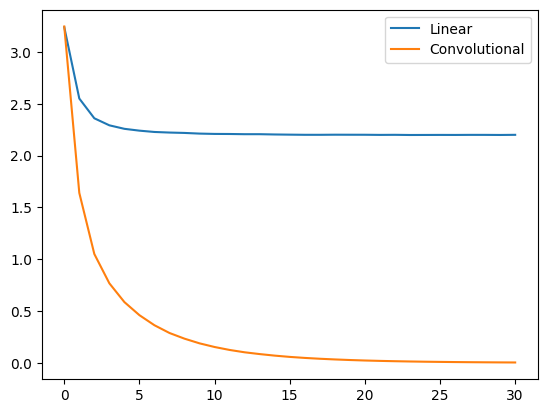

In [10]:
plt.plot(losses_l, label="Linear")
plt.plot(losses_c, label="Convolutional")
plt.legend()
plt.show()

In [202]:
np.tile(np.sin(np.linspace(0, to, n)), (n, 1)) + np.tile(np.cos(np.linspace(0, to, n)), (n, 1)).T

array([[ 1.00000000e+00,  1.72120245e+00,  1.99918900e+00, ...,
         8.11001828e-04,  2.78797553e-01,  1.00000000e+00],
       [ 6.92724354e-01,  1.41392680e+00,  1.69191335e+00, ...,
        -3.06464645e-01, -2.84780938e-02,  6.92724354e-01],
       [-4.02659401e-02,  6.80936507e-01,  9.58923058e-01, ...,
        -1.03945494e+00, -7.61468387e-01, -4.02659401e-02],
       ...,
       [-4.02659401e-02,  6.80936507e-01,  9.58923058e-01, ...,
        -1.03945494e+00, -7.61468387e-01, -4.02659401e-02],
       [ 6.92724354e-01,  1.41392680e+00,  1.69191335e+00, ...,
        -3.06464645e-01, -2.84780938e-02,  6.92724354e-01],
       [ 1.00000000e+00,  1.72120245e+00,  1.99918900e+00, ...,
         8.11001828e-04,  2.78797553e-01,  1.00000000e+00]])

# 2D Fourier stuff

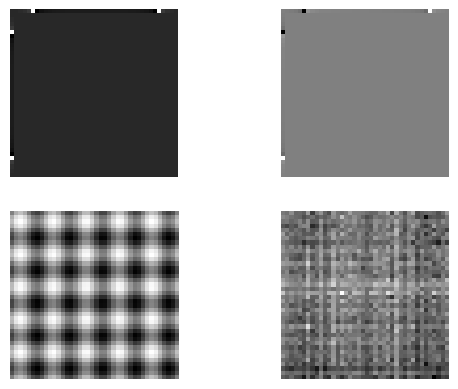

In [211]:
# inv = np.zeros((11, 11))
# inv[::2,:] = 1
# inv[:,::2] = 1
n = 40
to = np.pi * 10
# inv = np.tile(np.sin(np.linspace(0, to, n)), (n, 1))
inv = np.tile(np.sin(np.linspace(0, to, n)), (n, 1)) + np.tile(np.sin(np.linspace(0, to, n)), (n, 1)).T
t = np.fft.fft2(inv)
inv = np.fft.ifft2(t)

_, [[a1, a2], [a3, a4]] = plt.subplots(2, 2)
a1.imshow(t.real, cmap='gray')
a1.axis("off")
a2.imshow(t.imag, cmap='gray')
a2.axis("off")
a3.imshow(inv.real, cmap='gray')
a3.axis("off")
a4.imshow(inv.imag, cmap='gray')
a4.axis("off")
plt.show()

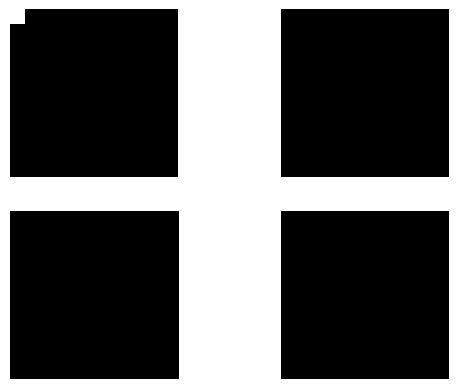

In [153]:
t = np.zeros((11, 11), dtype=np.complex64)
t[0, 0] = 1
# t[3, 6] = 1
inv = np.fft.ifft2(t)


_, [[a1, a2], [a3, a4]] = plt.subplots(2, 2)
a1.imshow(t.real, cmap='gray')
a1.axis("off")
a2.imshow(t.imag, cmap='gray')
a2.axis("off")
a3.imshow(inv.real, cmap='gray')
a3.axis("off")
a4.imshow(inv.imag, cmap='gray')
a4.axis("off")
plt.show()